# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import datetime

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
#azdias = pd.read_csv('data/AZDIAS.csv', sep=',')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=',')

In [3]:
azdias = pd.read_csv('data/AZDIAS.csv', sep=',')
customers = pd.read_csv('data/CUSTOMER.csv', sep=',')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


First 5 rows of both datasets, its shape and count of missing values in each datasets

In [4]:
display(azdias.head())

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
print(azdias.shape)

(891221, 367)


In [6]:
#display(azdias.isna().sum())

In [7]:
display(customers.head())

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [8]:
print(customers.shape)

(191652, 370)


In [9]:
#display(customers.isna().sum())

In [10]:
customers.shape

(191652, 370)

In [11]:
attribute_info = pd.read_excel('infos/DIAS Information Levels - Attributes 2017.xlsx',index_col=None, header=None ).drop(columns = 0, axis=1)
attribute_info.head()

,1,2,3,4
0,NaN,NaN,NaN,NaN
1,Information level,Attribute,Description,Additional notes
2,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
3,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
4,NaN,ANREDE_KZ,gender,NaN


In [12]:
more_info = pd.read_excel('infos/DIAS Attributes - Values 2017.xlsx',index_col=None, header=None)
more_info.head()

,0,1,2,3,4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,Attribute,Description,Value,Meaning
2,NaN,AGER_TYP,best-ager typology,-1,unknown
3,NaN,NaN,NaN,0,no classification possible
4,NaN,NaN,NaN,1,passive elderly


In [13]:
topics = attribute_info[~attribute_info[1].isna()][1].values
print(topics)

['Information level' 'Person' 'Household' 'Building' 'Microcell (RR4_ID)'
 'Microcell (RR3_ID)' '125m x 125m Grid' 'Postcode ' 'RR1_ID' 'PLZ8'
 'Community']


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [14]:
#data cleaning
def str2float(x):
    if type(x)==str:
        return eval(x)
    else:
        return x
    
def data_cleaning(df):
    '''
    Cleaning the data: replace some values,change string into number and change some 
    columns into categories and datatime.
    
    Parameters:
    INPUT:
    df(Dataframe): the dataset which will be cleaned
    
    OUTPUT:
    df(Datafrem): the cleaned dataset
    '''
    
    for column in ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']:
        #print(column)
        try:
            df[column][(df[column]=="X")|(df[column]=="XX")]=np.nan
        except:
            pass
        
    for column in ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']:
        df[column]=df[column].apply(str2float)
        #print(column)
    
    #change the catergory columns into number
    for column in ["CAMEO_DEU_2015","D19_LETZTER_KAUF_BRANCHE","OST_WEST_KZ",]:
        #print(column)
        df[column] = pd.Categorical(df[column])
        df[column] = df[column].cat.codes
        
    #extract the time,and keep the year   
    df["EINGEFUEGT_AM"]=pd.to_datetime(df["EINGEFUEGT_AM"]).dt.year
  
    temp_col = ["ALTERSKATEGORIE_GROB","ANREDE_KZ","GEBAEUDETYP","GEOSCORE_KLS7","HAUSHALTSSTRUKTUR",
            'HH_EINKOMMEN_SCORE',"KBA05_BAUMAX","KBA05_GBZ","KKK","NATIONALITAET_KZ","PRAEGENDE_JUGENDJAHRE",
            "REGIOTYP","TITEL_KZ","WOHNDAUER_2008","WACHSTUMSGEBIET_NB","W_KEIT_KIND_HH"]
    for column in temp_col:
        #print(column)
        try:
            df[column][(df[column]==0)(df[column]==-1)]=np.nan
        except:
            pass
        
    temp_col= ['KBA05_ALTER1','KBA05_ALTER2','KBA05_ALTER3','KBA05_ALTER4','KBA05_ANHANG','KBA05_AUTOQUOT',
             'KBA05_CCM1','KBA05_CCM2','KBA05_CCM3','KBA05_CCM4','KBA05_DIESEL','KBA05_FRAU','KBA05_HERST1',
             'KBA05_HERST2','KBA05_HERST3','KBA05_HERST4','KBA05_HERST5','KBA05_HERSTTEMP','KBA05_KRSAQUOT',
             'KBA05_KRSHERST1','KBA05_KRSHERST2','KBA05_KRSHERST3','KBA05_KRSKLEIN','KBA05_KRSOBER','KBA05_KRSVAN',
             'KBA05_KRSZUL','KBA05_KW1','KBA05_KW2','KBA05_KW3','KBA05_MAXAH','KBA05_MAXBJ','KBA05_MAXHERST',
             'KBA05_MAXSEG','KBA05_MAXVORB','KBA05_MOD1','KBA05_MOD2','KBA05_MOD3','KBA05_MOD4','KBA05_MOD8',
             'KBA05_MODTEMP','KBA05_MOTOR','KBA05_MOTRAD','KBA05_SEG1','KBA05_SEG10','KBA05_SEG2','KBA05_SEG3',
             'KBA05_SEG4','KBA05_SEG5','KBA05_SEG6','KBA05_SEG7','KBA05_SEG8','KBA05_SEG9','KBA05_VORB0',
             'KBA05_VORB1','KBA05_VORB2','KBA05_ZUL1','KBA05_ZUL2','KBA05_ZUL3','KBA05_ZUL4','RELAT_AB',
             'SEMIO_DOM',
             'SEMIO_ERL','SEMIO_FAM','SEMIO_KAEM','SEMIO_KRIT','SEMIO_KULT','SEMIO_LUST','SEMIO_MAT',
             'SEMIO_PFLICHT',
             'SEMIO_RAT','SEMIO_REL','SEMIO_SOZ','SEMIO_TRADV','SEMIO_VERT','ZABEOTYP']
    for column in temp_col:
        #print(column)
        try:
            df[column][(df[column]==-1)(df[column]==9)]=np.nan
        except:
            pass

    for column in df.columns.values:
        #print(column)
        try:
            df[column][df[column]==-1]=np.nan
        except:
            pass
    
    #get rid of the rows which have the age is 0 which corresponds to NaN
    df['GEBURTSJAHR'][df['GEBURTSJAHR']==0]=np.nan
    df = df.drop(['Unnamed: 0'],axis = 1)
    return df

In [15]:
customers = data_cleaning(customers)

<ipython-input-14-87dd553767a6>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][(df[column]=="X")|(df[column]=="XX")]=np.nan
<ipython-input-14-87dd553767a6>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][df[column]==-1]=np.nan
<ipython-input-14-87dd553767a6>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GEBURTSJAHR'][df['GEBURTSJAHR']==0]=np.nan


In [16]:
# Check out unique values of ordinal features
display(["{}: {}".format(col_name, customers[col_name].unique()) for col_name in customers.columns])

['LNR: [  9626   9628 143872 ... 148813 148852 148883]',
 'AGER_TYP: [ 2. nan  1.  0.  3.]',
 'AKT_DAT_KL: [ 1.  9.  3.  7.  5.  2. nan  4.  6.  8.]',
 'ALTER_HH: [10. 11.  6.  8. 20.  5. 14. 21. 15. 17.  0. 19.  9. 12. 13. nan 18.  7.\n 16.  4.  2.  3.]',
 'ALTER_KIND1: [nan  8. 12.  9.  7. 13. 17. 14. 18. 11. 16.  6. 10. 15.  5.  3.  4.  2.]',
 'ALTER_KIND2: [nan  9. 17. 10. 14. 13. 12. 11. 16. 18. 15.  7.  5.  8.  6.  3.  2.  4.]',
 'ALTER_KIND3: [nan 13. 16. 18. 15. 17. 14. 12. 11. 10.  8.  7.  9.  6.  5.]',
 'ALTER_KIND4: [nan 18. 12. 16. 13. 17. 11. 14. 15. 10.  8.]',
 'ALTERSKATEGORIE_FEIN: [10. nan  0.  8. 14.  9.  4. 13.  6. 12. 19. 17. 15. 11. 16.  7. 18. 21.\n 25. 20. 24.  5.  2. 22.  3. 23.]',
 'ANZ_HAUSHALTE_AKTIV: [  1.  nan   0.   7.  74.   9.  17.  12.  29.   2.  45.  10.  14.  15.\n  55.   6.   5. 108.   3.  25.  18.   4.  11.  19.   8.  26.  43.  63.\n  47.  16.  31.  57.  37.  13.  22.  20.  23.  27. 305.  52.  21.  34.\n  46.  24.  33.  51. 523. 104. 101.  59.  44. 

In [17]:
azdias = data_cleaning(azdias)

<ipython-input-14-87dd553767a6>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][(df[column]=="X")|(df[column]=="XX")]=np.nan
<ipython-input-14-87dd553767a6>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][df[column]==-1]=np.nan
<ipython-input-14-87dd553767a6>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GEBURTSJAHR'][df['GEBURTSJAHR']==0]=np.nan


In [18]:
# Check out unique values of ordinal features
display(["{}: {}".format(col_name, azdias[col_name].unique()) for col_name in azdias.columns])

['LNR: [910215 910220 910225 ... 825772 825776 825787]',
 'AGER_TYP: [nan  2.  3.  0.  1.]',
 'AKT_DAT_KL: [nan  9.  1.  5.  8.  7.  6.  4.  3.  2.]',
 'ALTER_HH: [nan  0. 17. 13. 20. 10. 14. 16. 21. 11. 19. 15.  9. 18.  8.  7. 12.  4.\n  3.  6.  5.  2.  1.]',
 'ALTER_KIND1: [nan 17. 10. 18. 13. 16. 11.  6.  8.  9. 15. 14.  7. 12.  4.  3.  5.  2.]',
 'ALTER_KIND2: [nan 13.  8. 12. 10.  7. 16. 15. 14. 17.  5.  9. 18. 11.  6.  4.  3.  2.]',
 'ALTER_KIND3: [nan 10. 18. 17. 16.  8. 15.  9. 12. 13. 14. 11.  7.  5.  6.  4.]',
 'ALTER_KIND4: [nan 10.  9. 16. 14. 13. 11. 18. 17. 15.  8. 12.  7.]',
 'ALTERSKATEGORIE_FEIN: [nan 21. 17. 13. 14. 10. 16. 20. 11. 19. 15. 18.  9. 22. 12.  0.  8.  7.\n 23.  4. 24.  6.  3.  2.  5. 25.  1.]',
 'ANZ_HAUSHALTE_AKTIV: [ nan  11.  10.   1.   3.   5.   4.   6.   2.   9.   0.  14.  13.   8.\n   7.  44.  25.  36.  16. 272.  33.  15.  12.  22.  21.  20.  67.  23.\n  18.  27.  24.  31.  39.  19.  30.  17.  29.  61.  54.  88.  49.  60.\n  38.  34.  48.  35.  62. 

In [19]:
new_dict = {topic : [] for topic in topics}
#cur_topic = 'Information level'
for i, (topic, sub) in enumerate(zip(attribute_info[1], attribute_info[2])):
    if(topic is not np.nan):
        cur_topic = topic
        if(sub is not np.nan):
            new_dict[cur_topic].append(sub)
    
    if(topic is np.nan):
        if(sub is not np.nan):
            new_dict[cur_topic].append(sub)
str(new_dict)

"{'Information level': ['Attribute', 'AGER_TYP'], 'Person': ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP'], 'Household': ['ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HAUSHALTSSTRUKTUR', 'HH_EINKOMMEN_SCORE', 'D19_KK_KUNDENTYP', 'D19_KONSUMTYP', 'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24', 'D19_BANKEN_ ANZ_12             D

In [20]:
new_dict['Information level'] = new_dict['Information level'].pop(1)

In [21]:
new_dict['Information level']

'AGER_TYP'

In [22]:
print(sum(map(len, new_dict.values())))
print(len(more_info[1].unique()))

320
316


In [23]:
azdias_feat = pd.DataFrame(columns=['unique_values', 'percentage'])

In [24]:
for col in azdias.columns:
    values = int(len(azdias[col].unique()))
    percentage = round((np.sum(azdias[col].isna()) / azdias.shape[0])*100, 2)
    azdias_feat.loc[col] = [values, percentage]
    
azdias_feat = azdias_feat.sort_values(['percentage', 'unique_values'], ascending=False)
display(azdias_feat.head())
display(azdias_feat.tail())

,unique_values,percentage
ALTER_KIND4,13.0,99.86
ALTER_KIND3,16.0,99.31
ALTER_KIND2,18.0,96.69
ALTER_KIND1,18.0,90.90
AGER_TYP,5.0,76.02


,unique_values,percentage
KOMBIALTER,5.0,0.0
ALTERSKATEGORIE_GROB,5.0,0.0
NATIONALITAET_KZ,4.0,0.0
GREEN_AVANTGARDE,2.0,0.0
ANREDE_KZ,2.0,0.0


In [25]:
customer_feat = pd.DataFrame(columns=['unique_values', 'percentage'])
for col in customers.columns:
    values = int(len(customers[col].unique()))
    percentage = round((np.sum(customers[col].isna()) / customers.shape[0])*100, 2)
    customer_feat.loc[col] = [values, percentage]
    
customer_feat = customer_feat.sort_values(['percentage', 'unique_values'], ascending=False)
display(customer_feat.head())
display(customer_feat.tail())

,unique_values,percentage
ALTER_KIND4,11.0,99.88
ALTER_KIND3,15.0,99.33
ALTER_KIND2,18.0,97.34
ALTER_KIND1,18.0,93.86
KK_KUNDENTYP,7.0,58.41


,unique_values,percentage
PRODUCT_GROUP,3.0,0.0
GREEN_AVANTGARDE,2.0,0.0
CUSTOMER_GROUP,2.0,0.0
ONLINE_PURCHASE,2.0,0.0
ANREDE_KZ,2.0,0.0


In [26]:
#Difference between customer and azdias dataset
diff = np.setdiff1d(customers.columns, azdias.columns)
print(diff)

['CUSTOMER_GROUP' 'ONLINE_PURCHASE' 'PRODUCT_GROUP']


In [27]:
#Values of different features
for col in diff:
    print(str(col) + " - " + str(set(customers[col].values)))

CUSTOMER_GROUP - {'MULTI_BUYER', 'SINGLE_BUYER'}
ONLINE_PURCHASE - {0, 1}
PRODUCT_GROUP - {'COSMETIC_AND_FOOD', 'FOOD', 'COSMETIC'}


In [28]:
for col in diff:
    counts = customers[col].value_counts()
    sum_c = np.sum(customers[col].value_counts())
    print(str(col))
    print(25*"--")
    for idx in counts.index:
        print(str(idx) + ": " + str(round(counts[idx] / sum_c ,3) * 100) + "%")
        
    print(25*"=="+"\n\n")

CUSTOMER_GROUP
--------------------------------------------------
MULTI_BUYER: 69.0%
SINGLE_BUYER: 31.0%


ONLINE_PURCHASE
--------------------------------------------------
0: 91.0%
1: 9.0%


PRODUCT_GROUP
--------------------------------------------------
COSMETIC_AND_FOOD: 52.6%
FOOD: 24.7%
COSMETIC: 22.7%




In [29]:
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [30]:
# merge azdias and customers data, add CLASS column containing class labels 
azdias['CLASS'] = 0
customers['CLASS'] = 1
merge_data = pd.concat([azdias, customers], axis=0)

In [31]:
merge_data.shape

(1082873, 367)

In [32]:
del azdias
del customers

In [33]:
#del real_features

In [34]:
#real features 
real_label = merge_data['CLASS']

merge_data = merge_data.drop(columns = ['CLASS'])
merge_data.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


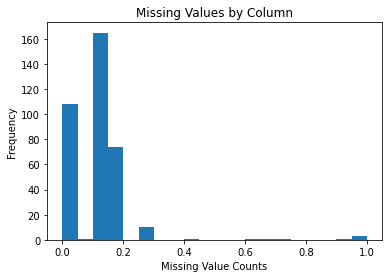

In [35]:
#count the total na in final dataset
na_counts = merge_data.isna().mean(axis=0)

na_counts.plot(kind='hist', bins=20)
plt.xlabel('Missing Value Counts')
plt.title('Missing Values by Column')

plt.show()

In [36]:
# drop the columns with many missing values to reduce noise
threshold = 0.5

index_rows_sub = (na_counts < threshold)
print(na_counts)

LNR                     0.000000
AGER_TYP                0.710711
AKT_DAT_KL              0.110904
ALTER_HH                0.110904
ALTER_KIND1             0.914280
                          ...   
WOHNDAUER_2008          0.110904
WOHNLAGE                0.132125
ZABEOTYP                0.000000
ANREDE_KZ               0.000000
ALTERSKATEGORIE_GROB    0.000000
Length: 366, dtype: float64


In [37]:
# Subset columns with the threshold  
index_cols_sub = na_counts < 0.4

features_sub = merge_data.loc[:, index_cols_sub]

In [38]:
print(merge_data.shape)
print(features_sub.shape)

(1082873, 366)
(1082873, 358)


In [39]:
# Subset columns with the threshold  
index_cols_sub = na_counts < 0.2

features_sub = merge_data.loc[:, index_cols_sub]

In [40]:
print(merge_data.shape)
print(features_sub.shape)

(1082873, 366)
(1082873, 348)


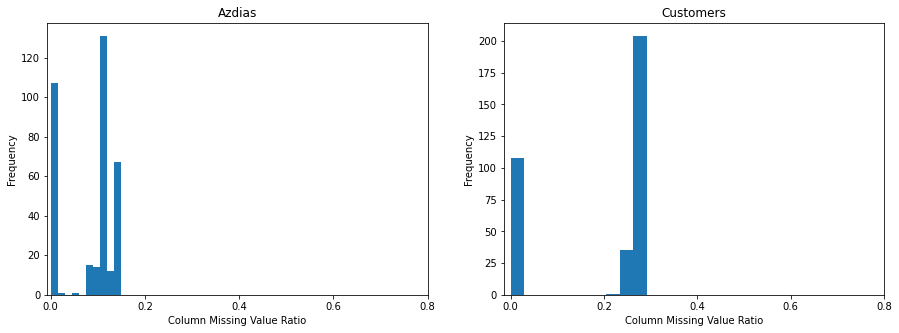

In [41]:
# Sanity Check
# Plot missing value distribution of the remaining columns of the 2 classes
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
features_sub[real_label==0].isna().mean(axis=0).plot(kind='hist')
plt.title('Azdias')
plt.xlabel('Column Missing Value Ratio')
plt.xticks(np.arange(0, 1, step=0.2))

plt.subplot(1, 2, 2)
features_sub[real_label==1].isna().mean(axis=0).plot(kind='hist')
plt.title('Customers')
plt.xlabel('Column Missing Value Ratio')
plt.xticks(np.arange(0, 1, step=0.2))

plt.show()


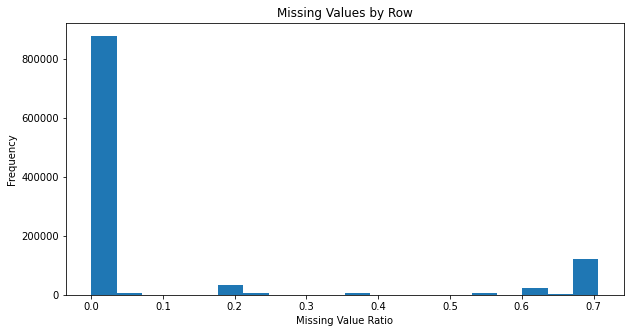

In [42]:
# treatment for rows
# Subset rows with row thresholna_countscounts 
na_count_rows = features_sub.isna().mean(axis=1)

plt.figure(figsize = (10, 5))
na_count_rows.plot(kind='hist', bins=20)
plt.xlabel('Missing Value Ratio')
plt.title('Missing Values by Row')

plt.show()

In [43]:
index_rows_sub = na_count_rows < 0.2
features_sub = features_sub.loc[index_rows_sub, :]
features_label = real_label[index_rows_sub]

In [44]:
print(features_sub.shape)
print(features_label.shape)

(915646, 348)
(915646,)


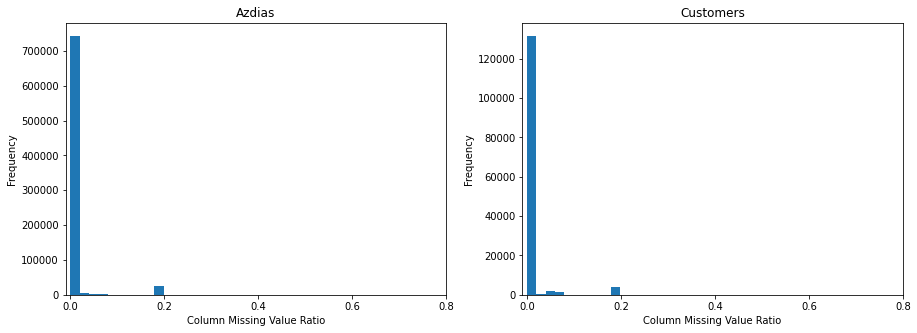

In [45]:
# Sanity Check
# Plot missing value distribution of the remaining columns of the 2 classes
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
features_sub[features_label==0].isna().mean(axis=1).plot(kind='hist')
plt.title('Azdias')
plt.xlabel('Column Missing Value Ratio')
plt.xticks(np.arange(0, 1, step=0.2))

plt.subplot(1, 2, 2)
features_sub[features_label==1].isna().mean(axis=1).plot(kind='hist')
plt.title('Customers')
plt.xlabel('Column Missing Value Ratio')
plt.xticks(np.arange(0, 1, step=0.2))

plt.show()


In [46]:
features_sub = features_sub.fillna(features_sub.mean())

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,9.0,0.0,11.0,0.000000,0.0,2.0,12.0,0.0,3.0,...,4.0,8.0,11.0,10.0,3.000000,9.0,4.0,5,2,1
2,910225,9.0,17.0,10.0,0.000000,0.0,1.0,7.0,0.0,3.0,...,2.0,9.0,9.0,6.0,3.000000,9.0,2.0,5,2,3
3,910226,1.0,13.0,1.0,0.000000,0.0,0.0,2.0,0.0,2.0,...,0.0,7.0,10.0,11.0,4.061955,9.0,7.0,3,2,4
4,910241,1.0,20.0,3.0,0.000000,0.0,4.0,3.0,0.0,4.0,...,2.0,3.0,5.0,4.0,2.000000,9.0,3.0,4,1,3
5,910244,1.0,10.0,5.0,0.000000,0.0,1.0,2.0,0.0,2.0,...,2.0,10.0,7.0,4.0,6.000000,9.0,7.0,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,154561,1.0,9.0,1.0,0.000000,0.0,1.0,1.0,0.0,3.0,...,4.0,8.0,8.0,5.0,6.000000,9.0,1.0,3,1,3
191648,154563,2.0,0.0,0.0,0.043963,0.0,0.0,1.0,0.0,1.0,...,2.0,10.0,7.0,4.0,4.061955,9.0,3.0,3,2,4
191649,148813,1.0,15.0,1.0,0.000000,0.0,3.0,1.0,0.0,3.0,...,1.0,8.0,8.0,5.0,3.000000,9.0,3.0,3,1,4
191650,148852,1.0,13.0,4.0,0.000000,0.0,4.0,3.0,0.0,3.0,...,3.0,1.0,1.0,1.0,4.000000,9.0,2.0,3,2,3


In [47]:
features_sub.head(5)

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,9.0,0.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,20.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


In [94]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [95]:
#drop the unnecessary columns
features_scaled.drop("LNR",axis=1,inplace=True)

In [97]:
features_scaled=pd.DataFrame(scaler.fit_transform(features_sub.astype(float)),columns=features_sub.columns)

In [98]:
features_scaled.describe()

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,915646.000000,915646.000000,915646.000000,915646.000000,910097.000000,915646.00000,915646.000000,915646.000000,915646.000000,911212.000000,...,893466.000000,912239.000000,912239.000000,912239.000000,876555.000000,915646.000000,915646.000000,915646.000000,915646.000000,915646.000000
mean,0.512016,0.375828,0.521887,0.013140,0.002198,0.01358,0.040376,0.016001,0.001320,0.265153,...,0.604587,0.475578,0.506286,0.451132,0.676993,0.882839,0.501662,0.447450,0.492524,0.240323
std,0.283744,0.446419,0.354312,0.025856,0.017597,0.04529,0.027016,0.031648,0.017318,0.126227,...,0.290782,0.292914,0.281338,0.287956,0.317417,0.226841,0.244451,0.286992,0.499944,0.133288
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.271205,0.000000,0.000000,0.001681,0.000000,0.00000,0.022222,0.002227,0.000000,0.125000,...,0.500000,0.200000,0.250000,0.200000,0.333333,0.875000,0.375000,0.400000,0.000000,0.125000
50%,0.513111,0.000000,0.619048,0.005042,0.000000,0.00000,0.022222,0.006682,0.000000,0.250000,...,0.500000,0.500000,0.500000,0.400000,0.666667,1.000000,0.375000,0.400000,0.000000,0.250000
75%,0.758330,1.000000,0.809524,0.015126,0.000000,0.00000,0.044444,0.017817,0.000000,0.375000,...,0.750000,0.700000,0.750000,0.700000,1.000000,1.000000,0.625000,0.600000,1.000000,0.375000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [104]:
features_scaled = features_scaled.fillna(features_scaled.mean())

In [105]:
display(["{}: {}".format(col_name, features_scaled[col_name].unique()) for col_name in features_scaled.columns])

['LNR: [0.8405601  0.84056472 0.84056564 ... 0.13742344 0.13745946 0.13748809]',
 'AKT_DAT_KL: [1.    0.    0.5   0.875 0.625 0.375 0.25  0.75  0.125]',
 'ALTER_HH: [0.         0.80952381 0.61904762 0.95238095 0.47619048 0.66666667\n 0.76190476 1.         0.9047619  0.71428571 0.52380952 0.42857143\n 0.85714286 0.38095238 0.33333333 0.57142857 0.14285714 0.19047619\n 0.28571429 0.23809524 0.0952381  0.04761905]',
 'ANZ_HAUSHALTE_AKTIV: [0.01848739 0.01680672 0.00168067 0.00504202 0.00840336 0.00672269\n 0.01008403 0.00336134 0.01512605 0.         0.02352941 0.02184874\n 0.01344538 0.01176471 0.07394958 0.04201681 0.0605042  0.45714286\n 0.05546218 0.02521008 0.02016807 0.03697479 0.03529412 0.03361345\n 0.03865546 0.0302521  0.04537815 0.04033613 0.05210084 0.06554622\n 0.02689076 0.03193277 0.05042017 0.02857143 0.0487395  0.10252101\n 0.0907563  0.14789916 0.08235294 0.10084034 0.06386555 0.05714286\n 0.05882353 0.10420168 0.04369748 0.07563025 0.07058824 0.04705882\n 0.12941176 0.07

In [106]:
x_scaled=scaler.transform(features_scaled)

In [107]:
# Fit PCA model with 90% variance reserved and transform the original features to PCA features
pca = PCA(n_components=0.9)
features_PCA = pca.fit_transform(x_scaled)

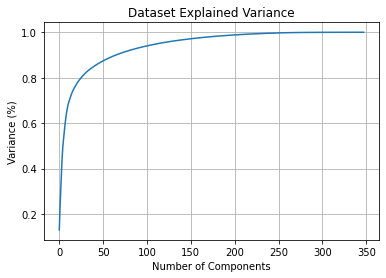

In [108]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(x_scaled)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.grid()
plt.show()

In [ ]:
# to determine the number of clusters
costs=[]
for k in range(3,40):
    kmeans = KMeans(n_clusters=k, random_state=0,n_jobs=-1).fit(dataset)
    costs.append(kmeans.inertia_)
    
    
#change of distance with the number of culsters
plt.plot(range(3,30),costs)
plt.xlabel("number of cluster")
plt.ylabel("Sum of distance")
plt.show()


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.war

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')